## Brute force : multinomial naive bayes on basic features
* Default parameters for multinomial naive bayes
* No cross validation, no hyper parameters
* train is done on unbalanced data (distribution of is_duplicate is not the same on train(37%) and challenge data (17%) !)

*BUT* a bunch of features are tested
* Compute common_words between question1 & question2
* Compute Nb common_words between question1 & question2
* Compute Nb common words/nb words in question1
* Compute Nb common words/nb words in question2
* Compute Nb words in question1,question2 not in common words
* Compute (nb common words)/(nb words in question1+nb word in question2)
These features are combined to generate 255 models (*2 as bot models with or without tests are trained)

# Sequence
* All features are generated
    * on training data
    * on challenge data (overkill as some features may be rejected later but easier)
* AUC graphs are computed for each single feature, hoping we can visually see if it is potentially useful or obviously useless
* 2 Models are trained on *ALL* combination of features
    * on a a partition train+validation=80 test=20
    * on full training data 
* Performances of all models are saved in a excel file
    * logloss on proba (test+full)
    * logloss on decision (test+full)
    * accuracy (test+full)
    * score (weighted combination of f1-score) (test+full)
* Various requests on this database of performances are done
* Apply is done on best 3 models (test & full)
    * proba is generated in a csv
    * csv is zipped
    * command line to publish in kaggle is displayed (no automatic submission to keep control)
* Kaggle performances are downloaded and saved
* Various requests on kaggle performances are done

In [33]:
# Ugly incantation to make our framework working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools (paths, cache, print,zip,excel, pandas, progress,..)
from Tools.all import *

# setup the name of our experiment
# it will be used to store every result in a unique place
EXPERIMENT='multinomial_basic_features_unbalanced'

In [8]:
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]


def build_all_simple_features(dataframe):
    start_small()
    print_warning('Compute common_words between question1 & question2')
    add_column_from_column(dataframe,'nb_words_question1','question1',lambda x: len(x.split()))
    add_column_from_column(dataframe,'nb_words_question2','question2',lambda x: len(x.split()))
    print_warning('Compute Nb common_words between question1 & question2')
    add_column_from_columns(dataframe,'common_words',lambda r: list(set(r.question1.split())&set(r.question2.split())))
    add_column_from_column(dataframe,'nb_common_words','common_words',len)

    print_warning('Compute Nb common words/nb words in question1')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question1',lambda r: r.nb_common_words/max(1,r.nb_words_question1))
    print_warning('Compute Nb common words/nb words in question2')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question2',lambda r: r.nb_common_words/max(1,r.nb_words_question2))

    print_warning('Compute Nb words in question1,question2 not in common words')
    add_column_from_columns(dataframe,'nb_words_question1-common_words',lambda r: len(list(set(r.question1.split())-set(r.common_words))))
    add_column_from_columns(dataframe,'nb_words_question2-common_words',lambda r: len(list(set(r.question2.split())-set(r.common_words))))
    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_columns(dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)',lambda r: r.nb_common_words/(r.nb_words_question1+r.nb_words_question2))
    end_small()
    dataframe=dataframe.drop(columns='common_words')
    return dataframe

In [9]:
prepare_environnement(EXPERIMENT)
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

train_dataframe=load_or_build_dataframe('Training data + basic features','training_basic_features',build_all_simple_features,train_dataframe)
challenge_dataframe=load_or_build_dataframe('Challenge data + basic features','challenge_basic_features',build_all_simple_features,challenge_dataframe)

In [10]:
train_dataframe.head().transpose()

,0,1,2,3,4
id,0,1,2,3,4
qid1,1,3,5,7,9
qid2,2,4,6,8,10
question1,What is the step by step guide to invest in share market in india?,What is the story of Kohinoor (Koh-i-Noor) Diamond?,How can I increase the speed of my internet connection while using a VPN?,Why am I mentally very lonely? How can I solve it?,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?"
question2,What is the step by step guide to invest in share market?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,How can Internet speed be increased by hacking through DNS?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",Which fish would survive in salt water?
is_duplicate,0,0,0,0,0
nb_words_question1,14,8,14,11,13
nb_words_question2,12,13,10,9,7
nb_common_words,10,4,3,0,2
nb_common_words/nb_words_question1,0.714286,0.5,0.214286,0,0.153846


In [11]:
challenge_dataframe.head().transpose()

,0,1,2,3,4
test_id,0,1,2,3,4
question1,How does the Surface Pro himself 4 compare with iPad Pro?,Should I have a hair transplant at age 24? How much would it cost?,What but is the best way to send money from China to the US?,Which food not emulsifiers?,"How ""aberystwyth"" start reading?"
question2,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?,How much cost does hair transplant require?,What you send money to China?,What foods fibre?,How their can I start reading?
nb_words_question1,11,14,14,4,4
nb_words_question2,14,7,6,3,6
nb_common_words,2,4,4,0,3
nb_common_words/nb_words_question1,0.181818,0.285714,0.285714,0,0.75
nb_common_words/nb_words_question2,0.142857,0.571429,0.666667,0,0.5
nb_words_question1-common_words,9,10,8,4,1
nb_words_question2-common_words,11,3,2,3,3


## Compute AUC of these basic features and try to figure if there is a bit of information inside each one
ie is it helping to separate 1 from 0?

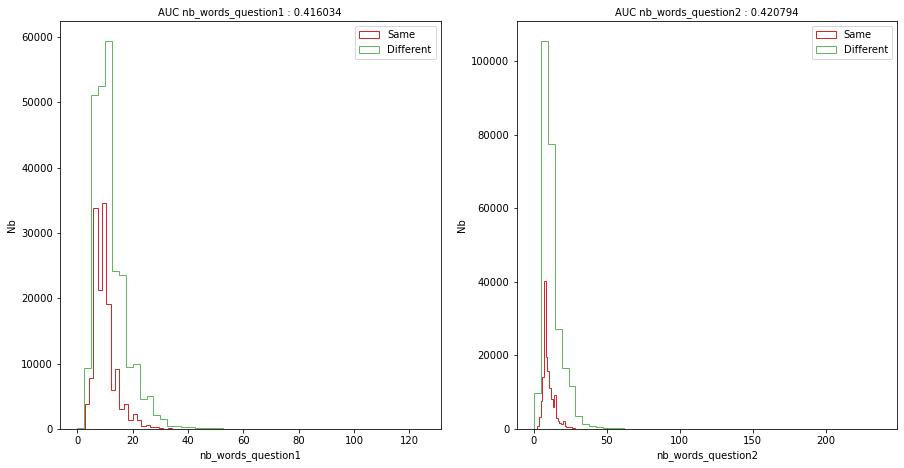

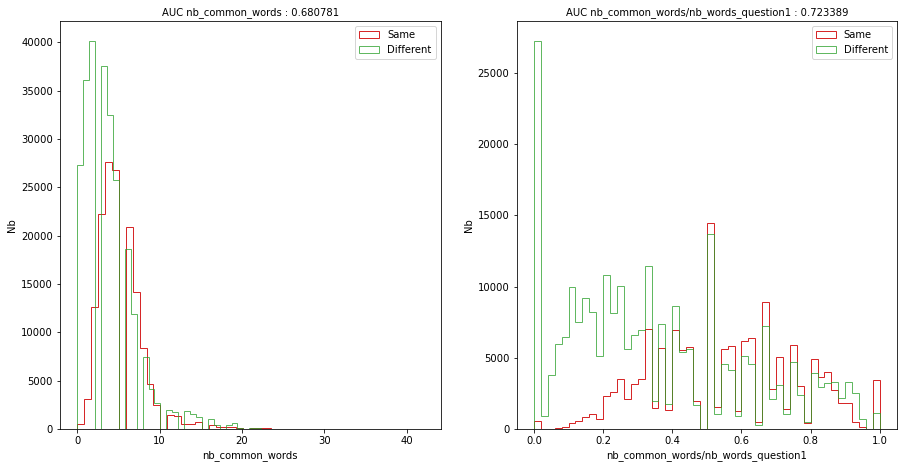

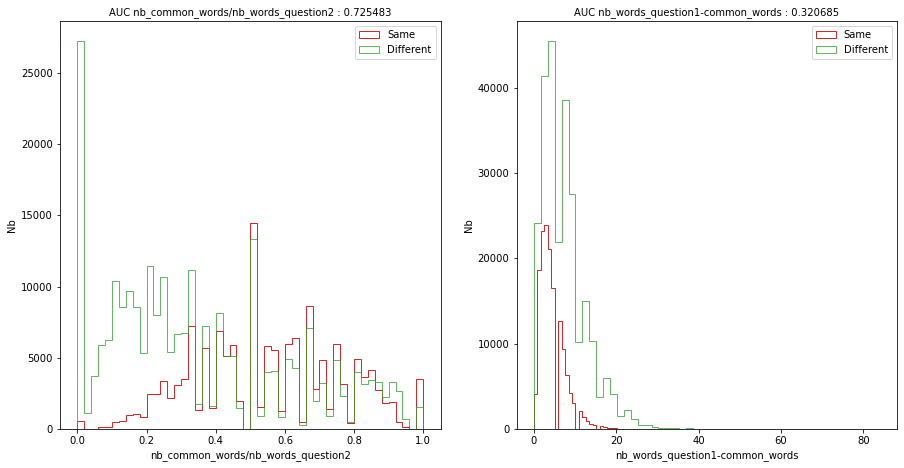

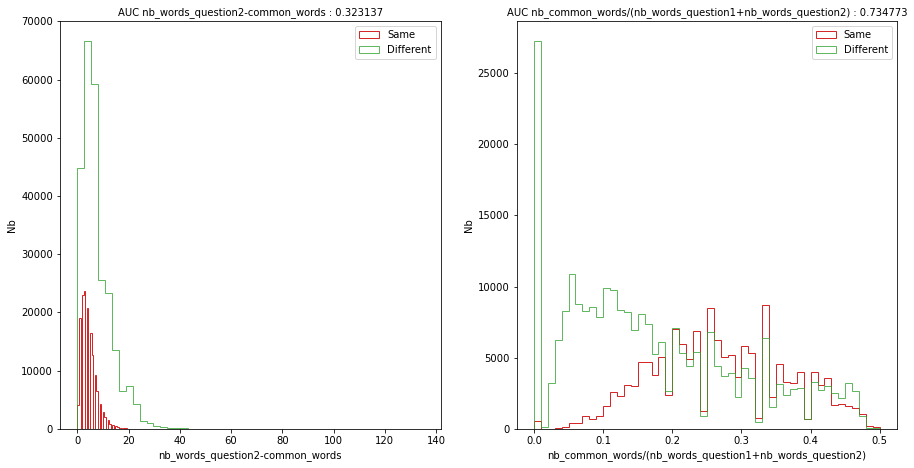

In [12]:
from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(dataframe['is_duplicate'],dataframe[column_name])

def show_AUC(dataframe,column_name):
    print_bullet('AUC %s: %f' % (column_name,simple_AUC(dataframe,column_name)))

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    # Let multiplot_generator figure the size
    #plot.figure(figsize=(10, 7))
    plot.hist(dataframe[column_name][dataframe['is_duplicate']==1],bins=50,color=palette[3],label='Same',histtype='step')
    plot.hist(train_dataframe[column_name][dataframe['is_duplicate']==0],bins=50,color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()


def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)
        yield
        display_simple_AUC(dataframe,name)
    print_done('Done')


def show_all_simple_AUC_in_grid(dataframe,nb_columns=2):
    multiplot_from_generator(show_all_simple_AUC(dataframe), nb_columns)

show_all_simple_AUC_in_grid(train_dataframe,nb_columns=2)



## As a quick check, Build simple naive bayes models (full & with test) on a fixed set of features
For both models, we return a performance record:
* time to train
* accuracy
* score (a ponderation on f1-score)
* logloss
* list of features
* model
* Nb features

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# This will add a suffix to all keys of a dict
# Used to add _test,_train,_full to keys of infos about a model

FAKE_INFOS_ON_MODEL_TEST_TRAIN = {
    'accuracy_train': 0,
    'score_train': 0,
    'logloss_proba_train': 0,
    'model_train': None,
    'accuracy_test': 0,
    'score_test': 0,
    'logloss_proba_test': 0,
    'model_test': None,
    'time_test':0
}

FAKE_INFOS_ON_MODEL_FULL = {
    'accuracy_full': 0,
    'score_full': 0,
    'logloss_proba_full': 0,
    'model_full': None,
    'time_full': 0
}


PRINT_INFOS_ON_2_MODELS = {
    'accuracy_test': '%.4f',
    'score_test': '%.4f',
    'logloss_proba_test': '%.4f',
    'time_test': '%.1f',

    'accuracy_train': '%.4f',
    'score_train': '%.4f',
    'logloss_proba_train': '%.4f',

    'accuracy_full': '%.4f',
    'score_full': '%.4f',
    'logloss_proba_full': '%.4f',
    'time_full': '%.1f',

    'nb_features': '%d',
    'column_names': '%s'
}

PRINT_INFOS_ON_MODEL_TRAIN = {
    'accuracy_train': '%.4f',
    'score_train': '%.4f',
    'logloss_proba_train': '%.4f',
}

PRINT_INFOS_ON_MODEL_TEST = {
    'accuracy_test': '%.4f',
    'score_test': '%.4f',
    'logloss_proba_test': '%.4f',
    'time_test': '%.1f',
}

PRINT_INFOS_ON_MODEL_FULL = {
    'accuracy_full': '%.4f',
    'score_full': '%.4f',
    'logloss_proba_full': '%.4f',
    'time_full': '%.1f',

}

def add_suffix_to_keys(d,s):
    return dict(zip([k+s for k in d.keys()],d.values()))

def format_model_infos(message,keys_formats,infos):
    values = list()
    for k,f in keys_formats.items():
        values.append( f % infos[k])
    #return print_info( '%s %s' %(message,'&nbsp;|&nbsp;'.join(values)))
    return '%s %s' %(message,' | '.join(values))

def print_model_infos(message,keys_formats,infos):
    print_info(format_model_infos(message,keys_formats,infos))
def print_header_infos_model(key_formats):
    print_info('|'.join(key_formats.keys()))

## Use & trick FAKE_XXXXX to mock the big loop of big trainings 
def FAKE_build_naivebayes_model_full(input,column_names,target,show=True):
    return FAKE_INFOS_ON_MODEL_FULL

def FAKE_build_naivebayes_model_with_test(input,column_names,target,show=True):
    return FAKE_INFOS_ON_MODEL_TEST_TRAIN

def FAKE_build_model(train_dataframe,column_names,target,show=True):
    infos = FAKE_build_naivebayes_model_with_test(train_dataframe,column_names,target,show=show)
    infos.update(FAKE_build_naivebayes_model_full(train_dataframe,column_names,target,show=show))
    infos.update(
        {
            'nb_features':len(column_names),
            'column_names':clean_combination_name(column_names),
            'columns': column_names
        })
    return infos



def compute_metrics_model(model,input_df,target_df,suffix,show=True):
    prediction_df = model.predict(input_df)
    prediction_proba_df = model.predict_proba(input_df)
    res = metrics.classification_report(target_df,prediction_df,output_dict=True)
    accuracy = res['accuracy']
    score = res['0']['f1-score']*(1-0.17)+res['1']['f1-score']*.17
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df)
    if show:
        print('Classification report on %s' % suffix)
        print(metrics.classification_report(target_df,prediction_df))
    return add_suffix_to_keys(
            {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           },
           suffix)


def build_naivebayes_model_with_test(input,column_names,target,show=True):
    # print_bullet('Multinomial Naive Bayes with test on %s' % clean_combination_name(column_names))
    input_train = pandas.DataFrame()
    for column_name in column_names:
        input_train[column_name]=input[column_name]
    target_train = target
    input_train,input_test,target_train,target_test = train_test_split(input_train,target_train,random_state=42,test_size=0.2)
    if show:
        print_info( 'Training:%d lines Test:%d Nb Features: %d' % (len(input_train),len(input_test),len(input_train.columns)))
    model = MultinomialNB()
    #naive_bayes_classifier_with_test=ComplementNB()
    start = time.time()
    model.fit(input_train,target_train)
    duration = time.time()-start
    infos = compute_metrics_model(model,input_test,target_test,'_test',show=show)
    infos.update(compute_metrics_model(model,input_train,target_train,'_train',show=show))
    infos.update({'time_test':duration})
    if show:      
        print_model_infos('Test ',PRINT_INFOS_ON_MODEL_TEST,infos)
        print_model_infos('Train ',PRINT_INFOS_ON_MODEL_TRAIN,infos)
    return  infos
    
def build_naivebayes_model_full(input,column_names,target,show=True):
    input_full = pandas.DataFrame()
    for column_name in column_names:
        input_full[column_name] = input[column_name]
    if show:
        print_info( 'Training on %dx%d' % (len(input_full),len(input_full.columns)))
    target_full = target
    model = MultinomialNB()
    start = time.time()
    model.fit(input_full,target_full)
    duration = time.time()-start
    infos = compute_metrics_model(model,input_full,target_full,'_full',show=show)
    infos.update({'time_full':duration})
    if show:
        print_model_infos('Full ',PRINT_INFOS_ON_MODEL_FULL,infos)
    return infos


def build_model(train_dataframe,column_names,target,show=True):
    infos = build_naivebayes_model_with_test(train_dataframe,column_names,target,show=show)
    infos.update(build_naivebayes_model_full(train_dataframe,column_names,target,show=show))
    infos.update(
        {
            'nb_features':len(column_names),
            'column_names':clean_combination_name(column_names),
            'columns': column_names
        })
    return infos

print_section('Quick check: Basic model using feature nb_words_question1')
build_model(train_dataframe,['nb_words_question1'],train_dataframe['is_duplicate'])



Classification report on _test
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     50803
           1       0.00      0.00      0.00     30055

    accuracy                           0.63     80858
   macro avg       0.31      0.50      0.39     80858
weighted avg       0.39      0.63      0.48     80858

Classification report on _train
              precision    recall  f1-score   support

           0       0.63      1.00      0.77    204224
           1       0.00      0.00      0.00    119208

    accuracy                           0.63    323432
   macro avg       0.32      0.50      0.39    323432
weighted avg       0.40      0.63      0.49    323432



Classification report on _full
              precision    recall  f1-score   support

           0       0.63      1.00      0.77    255027
           1       0.00      0.00      0.00    149263

    accuracy                           0.63    404290
   macro avg       0.32      0.50      0.39    404290
weighted avg       0.40      0.63      0.49    404290



{'accuracy_test': 0.6282989932968909,
 'score_test': 0.640531212735738,
 'logloss_proba_test': 0.6598757918253548,
 'model_test': MultinomialNB(),
 'accuracy_train': 0.631427935392911,
 'score_train': 0.6424864684567217,
 'logloss_proba_train': 0.6581913334694939,
 'model_train': MultinomialNB(),
 'time_test': 0.06068563461303711,
 'accuracy_full': 0.630802146973707,
 'score_full': 0.6420960175454294,
 'logloss_proba_full': 0.6585273839844356,
 'model_full': MultinomialNB(),
 'time_full': 0.0507969856262207,
 'nb_features': 1,
 'column_names': 'nb_words_question1',
 'columns': ['nb_words_question1']}

## Build models (test & full) on all combinations of features

In [14]:
# bad design choice : a DataFrame can be more convenient than a dict
# But then, it is convenient to suppress all non numeric/string columns
def models_dict_to_df(models_dict):
    # reorder also the columns in a way I use more convenient
    return pandas.DataFrame.from_dict(models_dict, orient='index').reindex(columns=['logloss_proba_test','logloss_proba_train','logloss_proba_full','nb_features','column_names','accuracy_test','accuracy_train','accuracy_full','score_test','score_train','score_full','model_test','model_train','model_full','columns','time_test','time_full'])

def build_model_on_all_subset_of_simple_features(dataframe,target):
    start = time.time()
    all_combinations = list(all_subsets(all_numeric_columns(dataframe)))
    steps_for_progress = int(len(all_combinations)/20)
    print_section('%s : Build all models (with test+full) on every combination of simple features - %d lines' % (EXPERIMENT,len(dataframe)))
    print_warning('%d*2 models built - only %d logged here' % (len(all_combinations),(int(len(all_combinations)/steps_for_progress))))
    models_dict = dict()
    print_header_infos_model(PRINT_INFOS_ON_2_MODELS)
    progress = tqdm(all_combinations)
    num_model = 0
    for c in progress:
        #if (len(c)) ==1:
        if (len(c)) >0:
            infos = build_model(dataframe,c,target,show=False)
            models_dict[clean_combination_name(c)] = infos
            # There is a smart panda progress bar but invisible in pdf
            # So try to minimize logs and still have some progress info
            if (num_model % steps_for_progress) == 0:
                  print_info(format_model_infos('',PRINT_INFOS_ON_2_MODELS,infos))
            num_model += 1
            progress.refresh()
    print_done('Done',top=start)
    # Design mistake : need to convert dict to dataframe :(
    return models_dict_to_df(models_dict)


def FAKE_build_model_on_all_subset_of_simple_features(dataframe,target):
    start = time.time()
    print_section('%s : Build all models (with test+full) on every combination of simple features - %d rows' % (EXPERIMENT,len(dataframe)))
    models_dict = dict()
    print_header_infos_model(PRINT_INFOS_ON_2_MODELS)
    all_combinations = list(all_subsets(all_numeric_columns(dataframe)))
    progress = tqdm(all_combinations)
    for c in progress:
        if (len(c)) >0:
            infos = FAKE_build_model(dataframe,c,target,show=False)
            models_dict[clean_combination_name(c)] = infos
            print_info(format_model_infos('',PRINT_INFOS_ON_2_MODELS,infos))
            progress.refresh()
    print_done('Done',top=start)
    # Design mistake : need to convert dict to dataframe :(
    return models_dict_to_df(models_dict)

## If you want to quickly validate some code, activate this massive subsampling 
Results will be useless but code coverage will be ok
This is also the good place to rebalance training data (cf next experiments)

In [15]:
# small_train_dataframe = train_dataframe.sample(20000)
# small_models = build_model_on_all_subset_of_simple_features(small_train_dataframe,small_train_dataframe['is_duplicate'])
# graph_all_metrics_all_models_in_grid(small_models,2)

In [16]:
# build ALL models
# Do not forget to keep the result !
# it's a dataframe with all infos on all models

# Use this line to mock up the loop
#FAKE_build_model_on_all_subset_of_simple_features(train_dataframe,train_dataframe['is_duplicate'])

model_results = build_model_on_all_subset_of_simple_features(train_dataframe,train_dataframe['is_duplicate'])


In [17]:
model_results.head().transpose()

,nb_words_question1,nb_words_question2,nb_common_words,nb_common_words/nb_words_question1,nb_common_words/nb_words_question2
logloss_proba_test,0.659876,0.659876,0.659876,0.659876,0.659876
logloss_proba_train,0.658191,0.658191,0.658191,0.658191,0.658191
logloss_proba_full,0.658527,0.658527,0.658527,0.658527,0.658527
nb_features,1,1,1,1,1
column_names,nb_words_question1,nb_words_question2,nb_common_words,nb_common_words/nb_words_question1,nb_common_words/nb_words_question2
accuracy_test,0.628299,0.628299,0.628299,0.628299,0.628299
accuracy_train,0.631428,0.631428,0.631428,0.631428,0.631428
accuracy_full,0.630802,0.630802,0.630802,0.630802,0.630802
score_test,0.640531,0.640531,0.640531,0.640531,0.640531
score_train,0.642486,0.642486,0.642486,0.642486,0.642486


## Graph metrics on all models generated

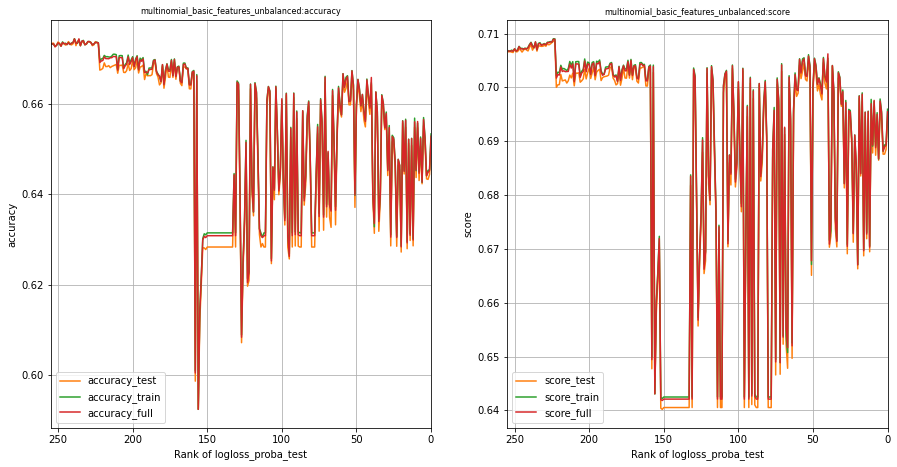

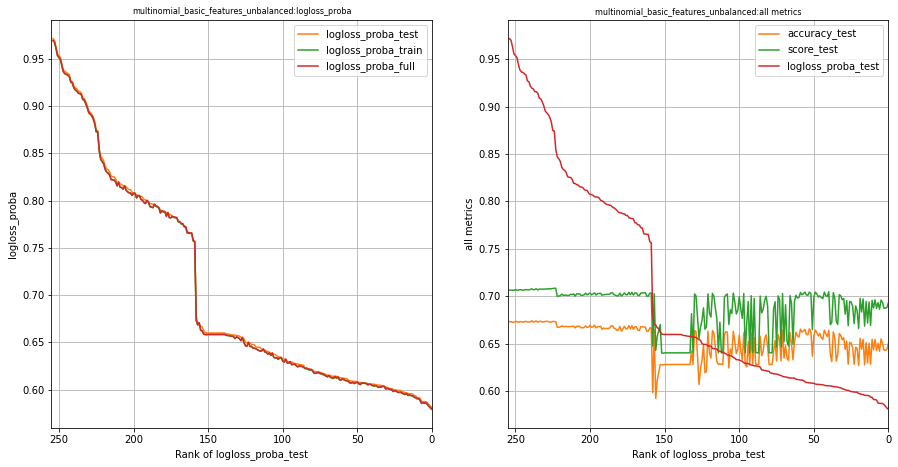

In [18]:

def graph_all_metric_all_models(results,y_label,metric_sort,metrics):
    palette = sns.color_palette()
    #data = results.sort_values(metric_sort+'_test',ascending=(metric_sort!='logloss_proba'))
    data = results.sort_values(metric_sort+'_test',ascending=(metric_sort=='logloss_proba'))
    plot.xlim(len(data),0)
    #data = results.sort_values('logloss_proba_test',ascending=False)
    #ax = plot
    # fig,ax = plot.subplots()
    x = numpy.arange(len(data))
    num_col=1
    if len(metrics)>1:
        kinds =['_test']
    else:
        kinds = ['_test','_train','_full']
    for k in kinds:
        for m in metrics:
                plot.plot(x,data[m+k],color = palette[num_col],label = m+k)
                num_col = num_col+1
    plot.ylabel(y_label)
    plot.xlabel('Rank of logloss_proba_test')
    #plot.plot(x,data['nb_features'],color=palette[num_col],label='Nb features')
    #plot.plot(x,data['time_full'],color = palette[num_col+1],label = 'time_full')
    plot.title(EXPERIMENT+':'+ y_label,fontsize=8)
    #plot.xticks(x)
    #ax.set_xticklabels(labels)
    plot.grid()
    plot.legend()


def graph_all_metrics_all_models(results):
    for m in ['accuracy','score','logloss_proba']:
        yield
        graph_all_metric_all_models(results,m,'logloss_proba',[m])
    yield
    graph_all_metric_all_models(results,'all metrics','logloss_proba',['accuracy','score','logloss_proba'])

def graph_all_metrics_all_models_in_grid(results,nb_columns=2):
    multiplot_from_generator(graph_all_metrics_all_models(results), nb_columns)
    
graph_all_metrics_all_models_in_grid(model_results,2)

* When submitting to kaggle, any digit may be important but visually, logloss graph on test,train, full are quite identical
* More convenient graph is the last one

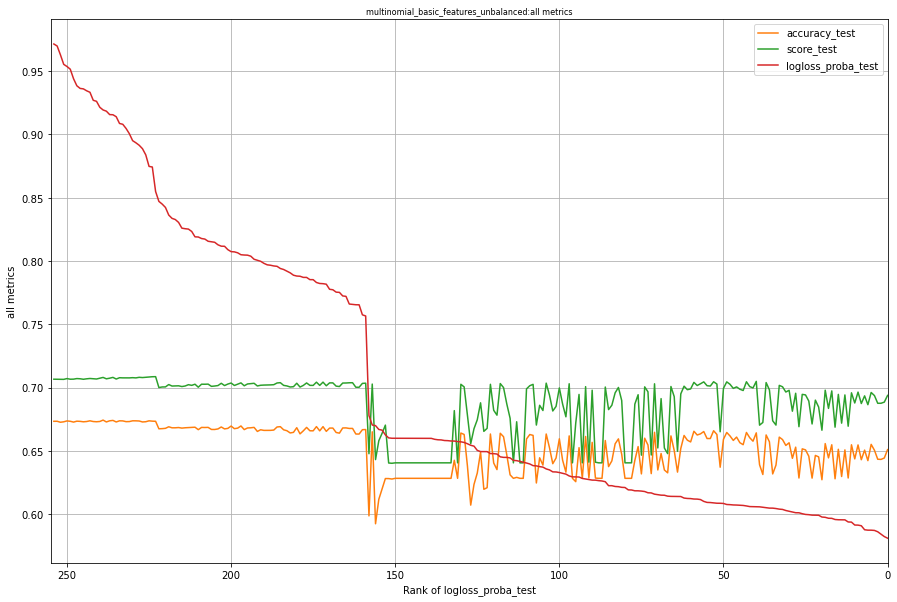

In [76]:

plot.figure(figsize=(15, 10))
graph_all_metric_all_models(model_results,'all metrics','logloss_proba',['accuracy','score','logloss_proba'])

## Query our 'database' of models

In [20]:
# Euark Suppose global variable model_results is available !

# kind is 'test or 'full'
def retrieve_model(model_key,kind):
    model = model_results['model_'+kind][model_key]
    column_names = model_results['columns'][model_key]
    return model,numpy.asarray(column_names)
    
# suppose global variable model_results is available
def find_best_models(top,criteria,kind):
    if 'logloss' in criteria:
        return model_results.nsmallest(top,criteria+'_'+kind)
    else:
        return model_results.nlargest(top,criteria+'_'+kind)

In [21]:
find_best_models(4,'logloss_proba','full')

,logloss_proba_test,logloss_proba_train,logloss_proba_full,nb_features,column_names,accuracy_test,accuracy_train,accuracy_full,score_test,score_train,score_full,model_test,model_train,model_full,columns,time_test,time_full
nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.581016,0.579103,0.579412,4,nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.650968,0.653312,0.652786,0.693784,0.695940,0.695453,MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words)",0.040949,0.048995
nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.582293,0.580427,0.580778,4,nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.644339,0.645400,0.645203,0.688499,0.689390,0.689231,MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",0.039219,0.049565
nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.584173,0.582167,0.582438,4,nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.643251,0.645227,0.644822,0.687594,0.689310,0.688958,MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",0.036961,0.049629
nb_common_words/nb_words_question1+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.586088,0.583858,0.584323,3,nb_common_words/nb_words_question1+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.643375,0.644083,0.644045,0.687585,0.688163,0.688145,MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",0.038851,0.047044


## Save our database of performances in a convenient Excel file

In [26]:
save_models_dict_to_excel(model_results)

## Do some scorings with our selection of models

In [22]:
# Here is how to rettrieve a specific model record
# retrieve_model('nb_common_words+nb_common_words/(nb_words_question1+nb_words_question2)','test')

# find best 4 full models based on logloss_proba
find_best_models(4,'logloss_proba','full')

,logloss_proba_test,logloss_proba_train,logloss_proba_full,nb_features,column_names,accuracy_test,accuracy_train,accuracy_full,score_test,score_train,score_full,model_test,model_train,model_full,columns,time_test,time_full
nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.581016,0.579103,0.579412,4,nb_common_words/nb_words_question1+nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words,0.650968,0.653312,0.652786,0.693784,0.695940,0.695453,MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words)",0.040949,0.048995
nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.582293,0.580427,0.580778,4,nb_common_words/nb_words_question1+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.644339,0.645400,0.645203,0.688499,0.689390,0.689231,MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",0.039219,0.049565
nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.584173,0.582167,0.582438,4,nb_common_words/nb_words_question2+nb_words_question1-common_words+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.643251,0.645227,0.644822,0.687594,0.689310,0.688958,MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question2, nb_words_question1-common_words, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",0.036961,0.049629
nb_common_words/nb_words_question1+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.586088,0.583858,0.584323,3,nb_common_words/nb_words_question1+nb_words_question2-common_words+nb_common_words/(nb_words_question1+nb_words_question2),0.643375,0.644083,0.644045,0.687585,0.688163,0.688145,MultinomialNB(),MultinomialNB(),MultinomialNB(),"(nb_common_words/nb_words_question1, nb_words_question2-common_words, nb_common_words/(nb_words_question1+nb_words_question2))",0.038851,0.047044


In [23]:

def show_docker_cp_command(absolute_file_name):
    return 'docker cp '+ DOCKER_IMAGE_NAME+':'+zip_file_name(absolute_file_name)+ ' c:\\temp\\outputs'

def show_kaggle_command(absolute_file_name):
    return 'kaggle competitions submit quora-question-pairs -f "' + zip_file_name(absolute_file_name) +'" -m "' + absolute_file_name +'"'

def show_docker_cp_commands(best_results):
    print_section('Use these commands to transfer apply results to windows host')
    for c in best_results['file_name'].apply(show_docker_cp_command):
        print_warning(c)
    print_done("")

def show_kaggle_commands(best_results):
    print_section('Use these commands to submit apply results to kaggle')
    for c in best_results['file_name'].apply(show_kaggle_command):
        print_warning(c)
    print_done("")
    
# return a dataframe fully ready to be converted in csv and published into kaggle
def simple_apply(model_key,input_dataframe,kind,proba=True):
    model,column_names=retrieve_model(model_key,kind)
    input_for_prediction=input_dataframe[column_names]
    res = pandas.DataFrame()
    if 'test_id' in input_dataframe.columns:
        res['test_id']=input_dataframe['test_id']
    if proba:
        res['is_duplicate']=pandas.Series(model.predict_proba(input_for_prediction)[:,1],name='is_duplicate')
    else:
        res['is_duplicate']=pandas.Series(model.predict(input_for_prediction),name='is_duplicate')
    return res  

def submit_model(criteria,kind,input_dataframe,model_key,proba=True,show_how_to_publish=True,kaggle=False):
    absolute_file_name_csv = apply_absolute_file_name(criteria,kind,model_key)
    print_info('Doing apply')
    prediction = simple_apply(model_key,input_dataframe,kind,proba)
    print_info('Generating CSV file')
    prediction.to_csv(absolute_file_name_csv,index=False)
    print_info('Zipping file')
    absolute_file_name_zip = zip_file_and_delete(absolute_file_name_csv)
    print_info('%s is ready' % absolute_file_name_csv)
    if show_how_to_publish:
        if kaggle:
            print_warning('Use this commands to submit apply results to kaggle')
            print_warning(show_kaggle_command(absolute_file_name_zip))
        else:
            print_warning('Use this command to transfer apply _results to Windows host')
            print_warning(show_docker_cp_command(absolute_file_name_csv))



def submit_best_models(top,criteria,kind,input_dataframe,proba=True,kaggle=False):
    print_section('Submit best %d %s models by %s' % (top,kind,criteria))
    best_models = find_best_models(top,criteria,kind)
    best_models['model_key']=numpy.asarray(best_models.index)
    #best_models['file_name']=numpy.array([apply_file_name(criteria,kind,n) for n in best_models.index])
    best_models['file_name']=best_models['model_key'].apply(lambda mk: apply_absolute_file_name(criteria,kind,mk))
    best_models['model_key'].apply(lambda mk: submit_model(criteria,kind,input_dataframe,mk,proba=proba,show_how_to_publish=False,kaggle=kaggle))
    best_models['docker']=best_models['file_name'].apply(show_docker_cp_command)
    best_models['kaggle']=best_models['file_name'].apply(show_kaggle_command)
    print_done('Done')
    if kaggle:
        show_kaggle_commands(best_models)
    else:
        show_docker_cp_commands(best_models)
    return best_models

## A basic apply

In [24]:
simple_apply('nb_common_words+nb_common_words/(nb_words_question1+nb_words_question2)',challenge_dataframe,'full')


,test_id,is_duplicate
0,0,0.368733
1,1,0.369118
2,2,0.369384
3,3,0.369198
4,4,0.373533
...,...,...
2345791,2345791,0.369198
2345792,2345792,0.369842
2345793,2345793,0.369198
2345794,2345794,0.358198


## Full apply
* Retrieve a set of best models
* for each model
    * score the model 
    * save the result in csv
    * zip the file
    * display the command to submit on kaggle

In [25]:
best_logloss_proba_test = submit_best_models(3,'logloss_proba','test',challenge_dataframe,kaggle=True)

# What Kaggle think about our submissions ?
## Get back all our submissions to kaggle

In [41]:
all_submissions = load_kaggle_submissions()

In [42]:
get_last_submissions(all_submissions)

,date,publicScore,privateScore,description,fileName
0,2020-09-10 21:24:17,0.49314,0.49464,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question2+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question2nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
1,2020-09-10 21:24:02,0.49074,0.49211,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
2,2020-09-10 21:23:42,0.49432,0.49583,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question1+nb_common_words_div_nb_words_question2+nb_words...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question1nb_common_words_div_nb_words_question2nb_words_question1-common_wordsnb_words_question2-common_words.zip


In [43]:
get_best_submissions(all_submissions)

,publicScore,date,privateScore,description,fileName
15,0.35408,2020-09-08 21:51:27,0.35579,first xgboost,simple_xgb.csv
1,0.49074,2020-09-10 21:24:02,0.49211,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
4,0.49109,2020-09-10 21:22:42,0.49246,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!full!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probafullnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...


In [44]:
get_best_submissions(all_submissions,metric='publicScore',n=5)

,publicScore,date,privateScore,description,fileName
15,0.35408,2020-09-08 21:51:27,0.35579,first xgboost,simple_xgb.csv
1,0.49074,2020-09-10 21:24:02,0.49211,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
4,0.49109,2020-09-10 21:22:42,0.49246,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!full!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probafullnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
0,0.49314,2020-09-10 21:24:17,0.49464,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question2+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question2nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...
3,0.49341,2020-09-10 21:23:05,0.49490,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!full!nb_common_words_div_nb_words_question2+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probafullnb_common_words_div_nb_words_question2nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...


# Graph our submissions (WIP)

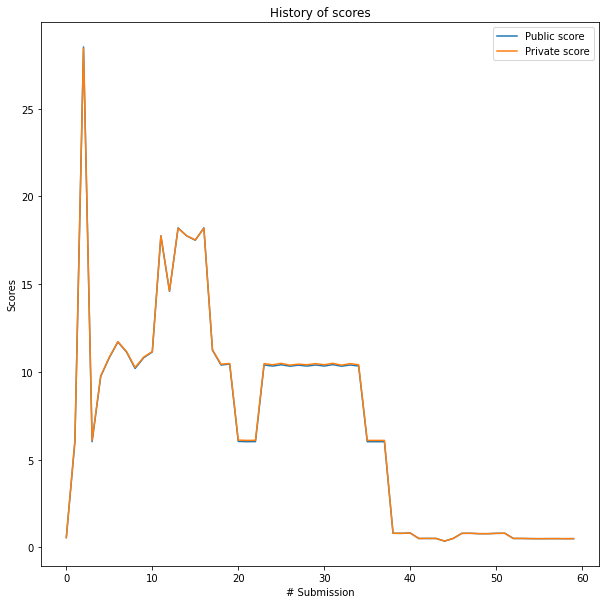

In [92]:
def display_submissions(dataframe):
    print_section( 'Show history of submissions')
    for name in ['publicScore']: #all_numeric_columns(dataframe):
        yield
        display_submission(dataframe)
    print_done('Done')

def display_submissions_in_grid(dataframe,nb_columns=2):
    multiplot_from_generator(display_submissions(dataframe), nb_columns)

def auto_label(rects):
    for rect in rects:
        height = rect.get_height()
        plot.annotate('{}'.format(height),xy=(rect.get_x()+rect.get_width()/2,height),xytext=(0,3),textcoords='offset points',ha='center',va='bottom')


# Only useful to show private/public is almost the same
# at least now
def display_submission_private_public(dataframe):
    #dataframe = dataframe[dataframe['publicScore']>0.4][dataframe['publicScore']<1]
    dataframe = dataframe.sort_values('date')
    labels = dataframe['description']
    public_scores = dataframe['publicScore']
    private_scores = dataframe['privateScore']
    x = numpy.arange(len(labels))
    width = 0.35
    fig = plot.figure(figsize=(20, 14))
    #ax = plot
    # fig,ax = plot.subplots()
    rects_public_score = plot.bar(x-width/2,public_scores,width,label = 'publicScore')
    rects_private_score = plot.bar(x+width/2,private_scores,width,label = 'privateScore')
    plot.ylabel('Scores')
    plot.title('History of scores')
    plot.xticks(x)
    #ax.set_xticklabels(labels)
    plot.legend()
    #auto_label(rects_public_score)
    fig.tight_layout()
    plot.show()

def find_description_test_and_full(dataframe):
    list_test = list()
    list_full = list()
    for i,d in dataframe.iterrows():
        #print(d)
        if d.description.find('!test!')>=0:
            list_test.append(d.description.replace('!test!','!x!'))
        if d.description.find('!full!')>=0:
            list_full.append(d.description.replace('!full!','!x!'))
    list_test_and_full = list(set(list_test)&set(list_full))
    list_test = [i.replace('!x!','test') for i in list_test_and_full]
    list_full = [i.replace('!x!','full') for i in list_test_and_full]
    return [i.replace('!x!','!test!') for i in list_test_and_full]+[i.replace('!x!','!full!') for i in list_test_and_full]
    
        

def display_submission_full_test_public(dataframe):
    #dataframe = dataframe[dataframe['publicScore']>0.4][dataframe['publicScore']<1]
    dataframe = dataframe.sort_values('date')
    test_and_full_scores = dataframe
    test_scores = test_and_full_scores[test_and_full_scores['description'].str.find('!test!')>=0]['publicScore']
    full_scores = test_and_full_scores[test_and_full_scores['description'].str.find('!full!')>=0]['publicScore']
    width = 0.35
    fig = plot.figure(figsize=(15, 10))
    #ax = plot
    # fig,ax = plot.subplots()
    x = numpy.arange(len(test_scores))
    rects_test_score = plot.bar(x-width/2,test_scores,width,label = 'Score on test')
    x = numpy.arange(len(full_scores))
    rects_full_score = plot.bar(x+width/2,full_scores,width,label = 'Score on full')
    plot.ylabel('Scores')
    plot.title('History of scores')
    plot.xticks(x)
    #ax.set_xticklabels(labels)
    plot.legend()
    #auto_label(rects_public_score)
    fig.tight_layout()
    plot.show()

# to check full and test models have been properly separated for further usage
# res = find_description_test_and_full(all_submissions)

# Only useful to show private/public is almost the same
# at least now
def display_submission_public(dataframe):
    #dataframe = dataframe[dataframe['publicScore']>0.4][dataframe['publicScore']<1]
    dataframe = dataframe.sort_values('date')
    x = numpy.arange(len(dataframe['description']))
    width = 0.35
    fig = plot.figure(figsize=(10, 10))
    #ax = plot
    #fig,ax = plot.subplots()
    plot.plot(x,dataframe['publicScore'],label='Public score')
    plot.plot(x,dataframe['privateScore'],label='Private score')
    plot.ylabel('Score')
    plot.xlabel('# Submission')
    plot.title('History of scores')
    plot.legend()
    plot.show()


### First scores were quite bad : logloss .... *28* !!!

In [102]:
print_section('Worst submissions based on publicScore')
all_submissions.nlargest(2,'publicScore')

,date,publicScore,privateScore,description,fileName
59,2020-09-02 15:59:20,28.52055,28.44654,All scores 1,AllOnes.csv
43,2020-09-08 14:26:27,18.20520,18.18134,10_score_full_nb_words_question2+nb_words_question2-common_words,10_score_full_nb_words_question2nb_words_question2-common_words.csv


In [103]:
print_section('Best submissions based on publicScore')
all_submissions.nsmallest(2,'publicScore')

,date,publicScore,privateScore,description,fileName
15,2020-09-08 21:51:27,0.35408,0.35579,first xgboost,simple_xgb.csv
1,2020-09-10 21:24:02,0.49074,0.49211,/SAPDevelop/QuoraPairs/multinomial_naivebayes_unbalanced/multinomial_naivebayes_unbalanced!logloss_proba!test!nb_common_words_div_nb_words_question1+nb_words_question1-common_words+nb_words_questi...,multinomial_naivebayes_unbalancedlogloss_probatestnb_common_words_div_nb_words_question1nb_words_question1-common_wordsnb_words_question2-common_wordsnb_common_words_div_(nb_words_question1nb_word...


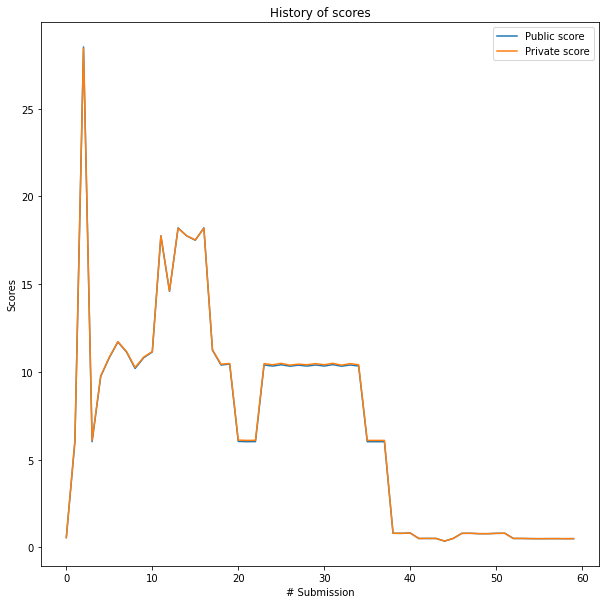

In [93]:
display_submission_public(all_submissions)